In [166]:
import pymongo 
import matplotlib
import string
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

In [74]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()

In [75]:
# Connecting to MongoDB 
client = pymongo.MongoClient("mongodb://localhost:27017")

In [76]:
"""
queries all the tweets for a given database and collection
"""
def find_all_tweets(db_client, db_name, coll_name):
    db = db_client[db_name]
    collection = db[coll_name]
    query = {}
    projection = {'tweet': 1, 'date': 1, '_id': 0}
    tweets = collection.find(query, projection)
    # Defining and executing a query to obtain an aggregated list of tweets per year 
    pipeline = [{'$project': {
            'tweet': 1,
            'year': {'$year': {'$dateFromString': {'dateString': '$date'}}}}},
    {'$group': {
            '_id': '$year',
            'tweets': {'$push': '$tweet'},
            'count': {'$sum': 1}}},
    {'$sort': {'_id': 1}}]
    
    results = list(collection.aggregate(pipeline))
    
    return results 

In [77]:
popular_tweets = find_all_tweets(client, "final_project", "popular_tweets")

In [78]:
all_tweets = find_all_tweets(client, "final_project", "all_tweets")

In [79]:
"""
clean/process the queried db tweets
"""
def process_tweets(results):
    for result in results: 
        tweets = result['tweets'] 
        processed_tweets = []
        for tweet in tweets: 
            s = tweet.lower()
            s = s.translate(str.maketrans("", "", string.punctuation))
            s = re.sub(r'\d+', '', s)
            
            # Append the processed string to the output list
            processed_tweets.append(s)
    # Replace the original tweets with the processed tweets
    result['tweets'] = processed_tweets
    
    return results

In [80]:
processed_pop_tweets = process_tweets(popular_tweets)

In [81]:
processed_tweets = process_tweets(all_tweets)

In [83]:
"""
conduct sentiment analysis on tweets 
"""
def analyze_sentiment(results):
    analyzer = SentimentIntensityAnalyzer()
    # defining an empty dictionary 
    year_sentiment = {}
    
    for result in results:
        # define year and list of tweets 
        year = result['_id']
        tweets = result['tweets'] 
        
        # use VADER to keep track of avg compound scores for a given year 
        sentiment_scores = [analyzer.polarity_scores(tweet)['compound'] for tweet in tweets] 
        year_sentiment[result['_id']] = (sum(sentiment_scores)/len(sentiment_scores)) * 100
        
    # yearly_df = pd.DataFrame(list(year_sentiment.items()), columns=['Year', 'Score'])
    yearly = list(year_sentiment.items())
    
    return yearly

In [87]:
columns = ['Year', 'Score']
pop_sentiment = analyze_sentiment(processed_pop_tweets)
pop_sentiment = spark.createDataFrame(pop_sentiment).toDF(*columns)

In [88]:
pop_sentiment.show()

+----+------------------+
|Year|             Score|
+----+------------------+
|2011|             86.25|
|2012|             15.86|
|2013| 46.08666666666667|
|2014|47.350606060606076|
|2015| 39.39236559139783|
|2016| 37.74074433656958|
|2017| 35.16291798107251|
|2018| 35.95295454545455|
|2019| 34.86875757575756|
|2020| 29.59877272727274|
|2021| 40.99916666666671|
|2022| 30.64028787878791|
+----+------------------+



In [89]:
sentiment = analyze_sentiment(processed_tweets)
sentiment = spark.createDataFrame(sentiment).toDF(*columns)
sentiment.show()

+----+------------------+
|Year|             Score|
+----+------------------+
|2008|32.328816388467324|
|2009|32.898672839506105|
|2010| 36.42741590214064|
|2011| 34.13387096774184|
|2012| 34.55852760736193|
|2013| 34.52748858447481|
|2014| 35.78484848484842|
|2015| 39.22528072837624|
|2016| 36.31049004594176|
|2017| 37.93500758725337|
|2018|37.495523520485605|
|2019| 32.59763803680977|
|2020| 29.86118195956448|
|2021|36.743138211382096|
|2022|27.691727828746167|
+----+------------------+



In [186]:
def calc_sentiment(results):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_list = []
    
    for result in results:
        # define year and list of tweets 
        year = result['_id']
        tweets = result['tweets'] 
        tweet_text = ' '.join(tweets)
        
        scores = analyzer.polarity_scores(tweet_text)
        
        # Extract the negative, positive, and neutral scores from the dictionary
        negative_score = scores["neg"]
        positive_score = scores["pos"]
        neutral_score = scores["neu"]
        
        # Calculate the percentage of negative, positive, and neutral sentiment in the text
        total_score = negative_score + positive_score + neutral_score
        negative_percentage = (negative_score / total_score) * 100
        positive_percentage = (positive_score / total_score) * 100
        
        # Create a dictionary with the year, positive and negative percentage
        sentiment_dict = {
            'Year': year,
            'negative_percentage': - negative_percentage,
            'positive_percentage': positive_percentage,
            'score': (positive_score - negative_score) * 100}
        sentiment_list.append(sentiment_dict)
        
    # Create a DataFrame from the list of dictionaries
    #df = pd.DataFrame(sentiment_list)
    
    
    return sentiment_list

In [187]:
pop_sentiment_precent = calc_sentiment(processed_pop_tweets)
pop_sentiment_precent = spark.createDataFrame(pop_sentiment_precent)

In [188]:
pop_sentiment_precent.show()

+----+-------------------+-------------------+------------------+
|Year|negative_percentage|positive_percentage|             score|
+----+-------------------+-------------------+------------------+
|2011|               -0.0|               42.0|              42.0|
|2012|-11.700000000000001|               16.8|5.1000000000000005|
|2013| -4.004004004004004| 24.024024024024026|              20.0|
|2014|               -4.0|               21.8|              17.8|
|2015| -5.805805805805806|  20.72072072072072|14.899999999999999|
|2016|               -8.0|               26.1|18.099999999999998|
|2017|  -9.50950950950951| 25.225225225225223|              15.7|
|2018|               -9.3| 20.200000000000003|10.900000000000002|
|2019|               -9.6|               20.3|10.700000000000001|
|2020|-10.299999999999999|               19.7| 9.400000000000002|
|2021| -8.008008008008009|  20.62062062062062|              12.6|
|2022|              -10.2| 19.900000000000002| 9.700000000000001|
+----+----

In [189]:
sentiment_precent = calc_sentiment(processed_tweets)
sentiment_precent = spark.createDataFrame(sentiment_precent)

In [190]:
sentiment_precent.show()

+----+-------------------+-------------------+------------------+
|Year|negative_percentage|positive_percentage|             score|
+----+-------------------+-------------------+------------------+
|2008|               -8.3| 24.099999999999998|15.799999999999997|
|2009|               -8.0| 23.599999999999998|15.599999999999998|
|2010|               -7.3|               25.7|              18.4|
|2011|              -10.6|               25.1|14.500000000000002|
|2012|               -7.9|               25.7|              17.8|
|2013| -8.108108108108107| 26.426426426426424|              18.3|
|2014| -7.507507507507507| 25.925925925925924|              18.4|
|2015|               -6.0| 26.200000000000003|20.200000000000003|
|2016| -7.807807807807807| 26.926926926926924|              19.1|
|2017| -8.200000000000001|               25.6|              17.4|
|2018| -8.799999999999999|               21.0|              12.2|
|2019|-10.100000000000001|               20.8|              10.7|
|2020|  -9

In [100]:
# reading in the cpi data 

cpi = spark.read.format("csv")\
            .option("header", "true")\
            .load('data/cpi-raw.csv')
cpi.show()

+----+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|Year|    Jan|    Feb|    Mar|    Apr|    May|    Jun|    Jul|    Aug|    Sep|    Oct|    Nov|    Dec| Annual|  HALF1|  HALF2|
+----+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2006|  198.3|  198.7|  199.8|  201.5|  202.5|  202.9|  203.5|  203.9|  202.9|  201.8|  201.5|  201.8|  201.6|  200.6|  202.6|
|2007|202.416|203.499|205.352|206.686|207.949|208.352|208.299|207.917|208.490|208.936|210.177|210.036|207.342|205.709|208.976|
|2008|211.080|211.693|213.528|214.823|216.632|218.815|219.964|219.086|218.783|216.573|212.425|210.228|215.303|214.429|216.177|
|2009|211.143|212.193|212.709|213.240|213.856|215.693|215.351|215.834|215.969|216.177|216.330|215.949|214.537|213.139|215.935|
|2010|216.687|216.741|217.631|218.009|218.178|217.965|218.011|218.312|218.439|218.711|218.803|219.179|218.056|2

In [173]:
cpi_diff = cpi.withColumn('annual_cpi_diff', 
               col('Annual') - lag('Annual', 1).over(Window.partitionBy().orderBy('Year')))
cpi_diff = cpi_diff.withColumn('Year', col("Year").cast(IntegerType()))
cpi_diff.show()

+----+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------------------+
|Year|    Jan|    Feb|    Mar|    Apr|    May|    Jun|    Jul|    Aug|    Sep|    Oct|    Nov|    Dec| Annual|  HALF1|  HALF2|    annual_cpi_diff|
+----+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------------------+
|2006|  198.3|  198.7|  199.8|  201.5|  202.5|  202.9|  203.5|  203.9|  202.9|  201.8|  201.5|  201.8|  201.6|  200.6|  202.6|               null|
|2007|202.416|203.499|205.352|206.686|207.949|208.352|208.299|207.917|208.490|208.936|210.177|210.036|207.342|205.709|208.976|  5.742000000000019|
|2008|211.080|211.693|213.528|214.823|216.632|218.815|219.964|219.086|218.783|216.573|212.425|210.228|215.303|214.429|216.177|  7.960999999999984|
|2009|211.143|212.193|212.709|213.240|213.856|215.693|215.351|215.834|215.969|216.177|216.330|215.949|214.537|213.139|

23/04/19 16:37:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/19 16:37:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/19 16:37:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [193]:
def sentiment_analysis_plot(df, title, cpi):
    #merge cpi data with sentiment data 
    all_df = df.join(cpi, "Year")
    
    bigdf = all_df.select("Year", "annual_cpi_diff", "positive_percentage", "negative_percentage", "score").collect()
    year, cpi_diff, pos, neg, score = zip(*bigdf)
    

    
    fig, ax1 = plt.subplots(figsize=(10,6))
    ax2 = ax1.twinx()
    # Create barplot with % vs year
    ax1.bar(year, pos, color='green', alpha=0.5, label = 'positive %')
    ax1.bar(year, neg, color='red', alpha=0.5, label = 'negative %')
    # Set labels and titles
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Sentiment Percentage')
    ax2.set_ylabel('CPI score')
    ax1.set_title(title)
    
    # Create lineplot with score vs year
    ax1.plot(year, score, color='black', linewidth=2, label = 'overall sentiment score')
    ax1.plot(year, [10000] * len(year), color='purple', label = "annual cpi difference")
    ax2.plot(year, cpi_diff, color='purple', linewidth=2)
    
    ax1.set_ylim([-10, 50])
    
    # Set x-axis ticks
    plt.xticks(year)
    ax1.legend()
    ax2.legend()
    # Show the plot
    plt.show()

23/04/19 16:45:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/19 16:45:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


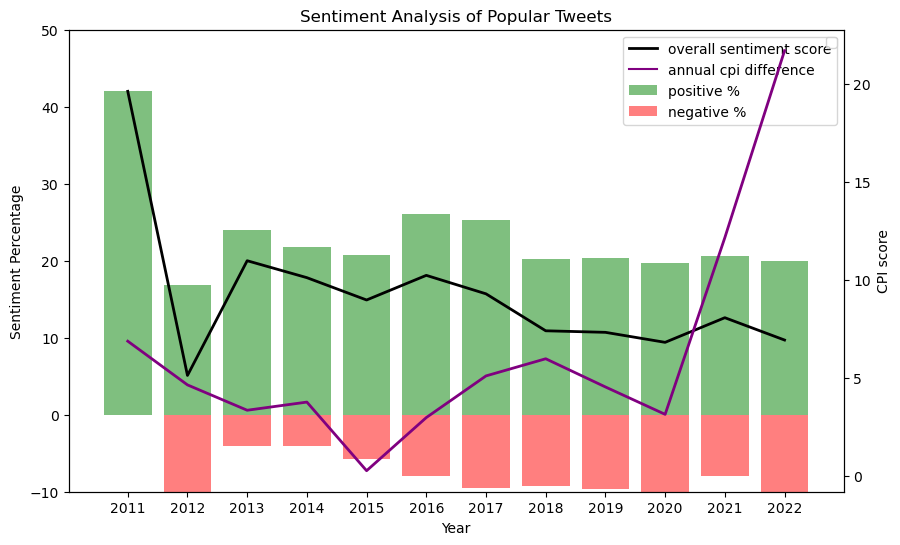

In [194]:
sentiment_analysis_plot(pop_sentiment_precent, "Sentiment Analysis of Popular Tweets", cpi_diff)

23/04/19 16:45:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/04/19 16:45:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


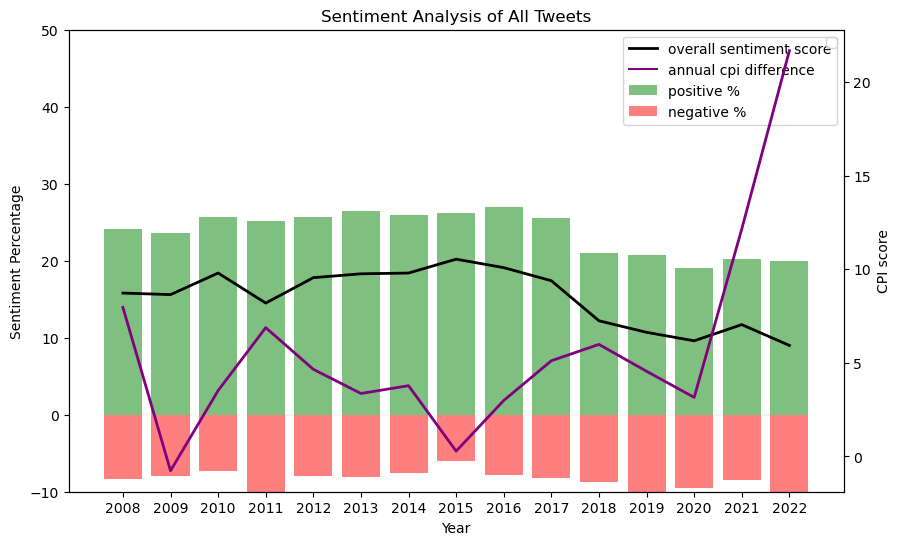

In [195]:
sentiment_analysis_plot(sentiment_precent, "Sentiment Analysis of All Tweets", cpi_diff)